<a href="https://colab.research.google.com/github/asozykin/demand_exploration/blob/main/Demand_space_exploration_20230206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
*   A nice way of printing generated forests (optional)
*   Presentation (PDF)
*   Blog post at asozykin.github.io


# Contents
*   Abstract
*   A population-scale model of organizational structure
*   Generating parametrized hierarchies
*   Simulation of the daily population output
*   Result 1: Population output entropy as a function of hierarchy parameter. Minimum and Maximum entropy hierarchies.
*   Meaning of the measured entropy
*   Result 2: Group effort towards a single goal as a function of hierarchy parameter. Minimum and Maximum group effort hierarchies.
*   Exploration/Exploitation dilemma
*   Demand exploration and Kullback-Leibler divergence between supply and changing demand
*   Consequences of inefficiency in demand exploration (informational pollution - feature creep, educational deficiency etc.)
*   Conclusion: symbiosis of polarized forests

# Abstract

Currently used [macroeconomic indicators](https://en.wikipedia.org/wiki/Macroeconomic_indicators) allow us to compare certain characteristics of different economies. Most of those metrics imply that different economies have similar structure - the existence of private property, markets, individuals, and businesses is assumed.

Theoretically, it is possible to construct an example of 2 economies having similar values for common macroeconomic indicators, but completely different otherwise. For example, one can take some today's real-world european state, call it Economy1, with known macroeconomic indicators, and construct a theoretical Economy2 such that it had same value for GDP, but with strict military rule, where all citizens are 100% occupied by the military service as soldiers or officers. Instead of property there will be materiel, instead of individuals and businesses - personnel and military units, and orders coming from the commander instead of shareholder's and manager's decisions.  

What measure of these two economies will best highlight their structural differences, given their equal GDP?

References to "quality of life", "human rights" and "freedom" as defined by Economy1 are empty and meaningless to members of Economy2. Vice versa there is a set of values defined in Economy2, which Economy1 won't understand. Also in daily life a citizen of Economy2 might feel almost the same as a citizen of Economy1. This person got used to the realities of Economy2 since childhood and feels just ok. This means that no poll can objectively highlight the difference.

This motivates the search for an unbiased numerical measure, which could be applied to Economy1 and Economy2 and could be used to demonstrate the differences between these two economies.

We aim to introduce the idea of an indicator which accounts for the amount of information produced by an economy.

We build a simplistic model of a population of people and the population's daily output (production). We then explore how structures in this group (organisational hierarchies, media etc.) influence the output.

We then demonstrate why economy-wide hierarchy meets e.g. military or agricultural needs, but appears to be in conflict with creation of new tech, products and services. We also show the way in which the interaction of economies like Economy1 and Economy2 may be symbiotic and profitable for the global community.

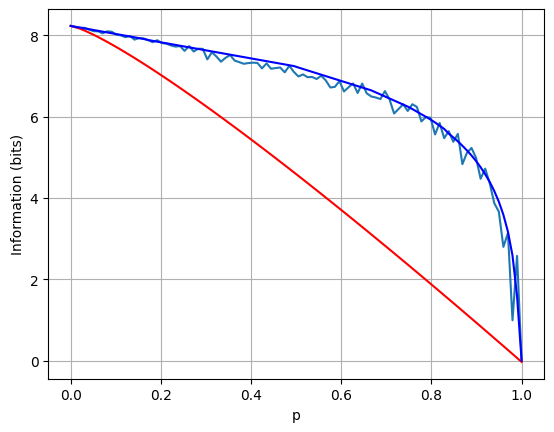

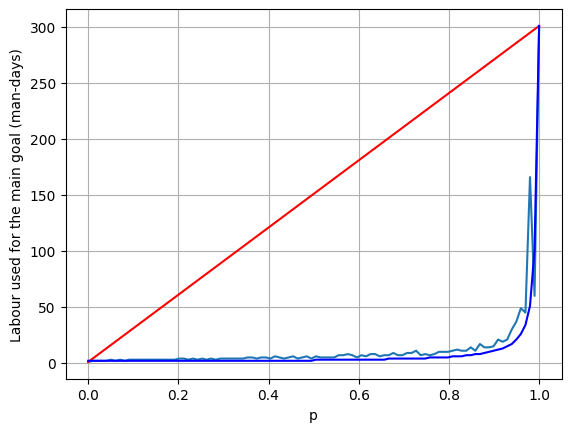

In [48]:
!pip install treelib

from __future__ import unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from treelib import Node, Tree
from scipy.stats import bernoulli, randint

# 1. Generate an ordered array of "nodes" resembling future forest
# 2. Uniformly sample a set of "founders", or roots of the trees in the forest.
# 3. Sample links from "subordinates" to "founders"
# 4. Visualize the set of hierarchies which results from this process.
# 5. Generate random node.data for each homo
# 6. Measure the output of information for each node and for the population

# // old ver, for deep forest generation - 2. Uniformly sample a "boss" (or no boss) for each node from a discrete uniform distribution.
# //Node has a boss with probability p, which is a parameter.
# //Boss has a higher id than a node (to exclude circular references and make it a hierarchy)


def generate_nodes(N, p):
  nodes = [] # a list of pairs (id, parent_id)
  founders = []

  for i in range(0, N): # sampling founders
    is_founder = bernoulli.rvs(1-p)
    if is_founder > 0:
      founders.append(i)

  if len(founders) == 0:
    founders.append(N-1)

  for i in range(0, N): # sampling links
    if not (i in founders):
      founder = random.choice(founders)
    else:
      founder = i
    nodes.append([i, founder])
  return nodes

def collect_children(nodes, t, parent_node):
  parent_id = parent_node.identifier
  for j in range(0, len(nodes)):
    # attach child node to current tree
    if nodes[j][1] == parent_id and nodes[j][0] != parent_id:
      child = t.create_node(j, j, parent = parent_id)

def nodes_to_forest(nodes):
  # create the first tree
  trees = []

  # we need as many trees as there are roots, so
  # select from nodes where id = parent_id
  for i in range(0, len(nodes)):
    if nodes[i][1] == i: # second column (parent_id) = node_id, thus founder
      t = Tree()
      trees.append(t)
      root_node = t.create_node(i, i) # No parent means it's the root node
      collect_children(nodes, t, root_node)
  return trees

def calc_shannon(forest, N):
  h = 0
  for t in forest:
    p = len(t.all_nodes())/N
    h = h - p*math.log2(p)
  return h

def calc_shannon_max_entropy_forest(N, p):
  ncols = max(round(N*(1-p)), 1) # number of columns in a grid
  nlongcols = N%ncols # number of columns with added residual nodes (long columns)
  shortlen = N//ncols # lenght of a short column equals floor(N/ncols)
#  print(ncols,'columns total, short = ', ncols-nlongcols, 'long = ', nlongcols)
#  print('short column length =', shortlen)
#  print('Test if N = shortlen * ncols + nlongcols:', 'N = ', N, '=', shortlen * ncols + nlongcols)
  hmax = -(ncols-nlongcols)*shortlen/N * math.log2(shortlen/N) - nlongcols*(shortlen+1)/N * math.log2((shortlen+1)/N)
  return hmax

def calc_shannon_min_entropy_forest(N, p):
  return (1-p-1/N)*math.log2(N) - (p+1/N)*math.log2(p+1/N)

def calc_energy(forest, N): # returns the size of the largest tree in a given forest
  maxtreesize = 0
  for t in forest:
    p = len(t.all_nodes())
    if maxtreesize < p:
      maxtreesize = p
  return maxtreesize

def calc_energy_max_entropy_forest(N, p): # theoretic maximum energy output for the maximum entropy forest
  ncols = max(round(N*(1-p)), 1) # just the length of a long column
  maxtreesize = N//ncols + 1
  return maxtreesize

def calc_energy_min_entropy_forest(N, p): # theoretic maximum energy output for the minimum entropy forest
  maxtreesize = N*p + 1 # just the number of subordinates + 1 (their boss). All the subordinates belong to the same tree
  return maxtreesize

N = 300
#p = 0.8 # probability for a node to be subordinate
k = 100 # >1, number of forests to generate in the loop below (min is 2 forests - for p = 0 and 1)

#nodes = generate_forest(N, p)
#nodes = [[0, 6], [1, 6], [2, 4], [3, 9], [4, 4], [5, 6], [6, 7], [7, 7], [8, 8], [9, 9]]

entropy_data = np.zeros((k, 2))
entropy_theory_lo = np.zeros((k, 2))
entropy_theory_hi = np.zeros((k, 2))
energy_data = np.zeros((k, 2))
energy_theory_lo = np.zeros((k, 2))
energy_theory_hi = np.zeros((k, 2))

for i in range(k): # loop through k+1 values of p
  p = i/(k-1)

  # generate forest for p in [0..1]
  nodes = generate_nodes(N, p)
  forest = nodes_to_forest(nodes)

  # calculate Shannon information in bits for each forest
  h = calc_shannon(forest, N)

  # put the pair (p, H(p-forest)) into an array for plotting
  entropy_data[i,:] = (p, h)

  # add theoretical values
  hmin = calc_shannon_min_entropy_forest(N, p)
  entropy_theory_lo[i,:] = (p, hmin) # min entropy forest

  hmax = calc_shannon_max_entropy_forest(N, p)
  entropy_theory_hi[i,:] = (p, hmax) # max entropy forest

  # now the same for energy
  e = calc_energy(forest, N)
  energy_data[i,:] = (p, e)
  emin = calc_energy_min_entropy_forest(N, p)
  energy_theory_lo[i,:] = (p, emin)
  emax = calc_energy_max_entropy_forest(N, p)
  energy_theory_hi[i,:] = (p, emax)

#print(chart_data)

# entropy chart
fig, ax = plt.subplots()
ax.plot(entropy_data[:,0], entropy_data[:,1])
ax.plot(entropy_theory_lo[:,0], entropy_theory_lo[:,1], color="red")
ax.plot(entropy_theory_hi[:,0], entropy_theory_hi[:,1], color="blue")

ax.set(xlabel='p', ylabel='Information (bits)')
ax.grid()

plt.show()

# energy chart
fig, ax = plt.subplots()
ax.plot(energy_data[:,0], energy_data[:,1])
ax.plot(energy_theory_lo[:,0], energy_theory_lo[:,1], color="red")
ax.plot(energy_theory_hi[:,0], energy_theory_hi[:,1], color="blue")

ax.set(xlabel='p', ylabel='Labour used for the main goal (man-days)')
ax.grid()

plt.show()


In [43]:
# treelib testing ground
from treelib import Node, Tree
tree = Tree()
tree.create_node("Harry", "harry")  # root node
tree.create_node("Jane", "jane", parent="harry")
tree.create_node("Bill", "bill", parent="harry")
tree.create_node("Diane", "diane", parent="jane")
tree.create_node("Mary", "mary", parent="diane")
tree.create_node("Mark", "mark", parent="jane")
print(tree)
tree.to_json()

Harry
├── Bill
└── Jane
    ├── Diane
    │   └── Mary
    └── Mark



'{"Harry": {"children": ["Bill", {"Jane": {"children": [{"Diane": {"children": ["Mary"]}}, "Mark"]}}]}}'

In [65]:
# debug
N = 10
p = 0.5
nodes = generate_nodes(N, p)
print(nodes)
print('count = ', len(nodes))
forest = nodes_to_forest(nodes)
for tree in forest:
#  print(tree.to_json(), '\n')
  print(tree)

print('entropy:', calc_shannon_min_entropy_forest(N, p), '<', calc_shannon(forest, N), '<', calc_shannon_max_entropy_forest(N, p))
print('energy:', calc_energy_max_entropy_forest(N, p), '<', calc_energy(forest, N), '<', calc_energy_min_entropy_forest(N, p))



[[0, 2], [1, 1], [2, 2], [3, 5], [4, 1], [5, 5], [6, 1], [7, 7], [8, 1], [9, 1]]
count =  10
1
├── 4
├── 6
├── 8
└── 9

2
└── 0

5
└── 3

7

entropy: 1.7709505944546686 < 1.7609640474436812 < 2.321928094887362
energy: 3 < 5 < 6.0


In [ ]:
# debug
import numpy as np
import math

'''
print(-math.log2(0.2)) # max full 5x2
print(-0.6*math.log2(0.3) - 0.4*math.log2(0.2)) # max overflown 2x3 + 2x2
print(-0.2*math.log2(0.1) - 0.8*math.log2(0.2)) # max classic 2x1 + 4x2
print(-0.3*math.log2(0.1) - 0.7*math.log2(0.7)) # min 3x1 + 1x7
print(-0.4*math.log2(0.1) - 0.6*math.log2(0.6)) # max 4x1 + 1x6
print(-0.5*math.log2(0.5) - 0.5*math.log2(0.5)) # max 2x5, p = 0.9, N = 10
'''
N = 4
p = 0.64 # probability of a node being subordinate
ncols = max(round(N*(1-p)), 1) # number of columns in a grid
nlongcols = N%ncols # number of columns with added residual nodes (long columns)
shortlen = N//ncols # lenght of a short column equals floor(N/ncols)
print(ncols,'columns total, short = ', ncols-nlongcols, 'long = ', nlongcols)
print('short column length =', shortlen)
print('Test if N = shortlen * ncols + nlongcols:', 'N = ', N, '=', shortlen * ncols + nlongcols)

1 columns total, short =  1 long =  0
short column length = 4
Test if N = shortlen * ncols + nlongcols: N =  4 = 4
